In [2]:
# 导入所需的库和模块 Import required libraries and modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor
import tensorflow as tf
from tensorflow import keras
import numpy as np
from torch.utils.data import DataLoader, RandomSampler

In [3]:
# 从 TensorFlow 加载 Fashion MNIST 数据集 Load the Fashion MNIST dataset from TensorFlow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
# 数据预处理：将像素值从 [0, 255] 缩放到 [0, 1] 范围，并增加一个通道维度 Data preprocessing: scale pixel values from [0, 255] to [0, 1] range and add a channel dimension
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., tf.newaxis] # 在最后增加一个新的维度，为单通道维度 Add a new dimension at the end, which is a single-channel dimension
x_test = x_test[..., tf.newaxis] # 同上 Same as above

In [5]:
# 定义一个卷积神经网络模型 Define a convolutional neural network model
def create_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(), # 将多维输入一维化 Convert multidimensional input to one dimension
        tf.keras.layers.Dense(64, activation='relu'), # 密集连接层 Densely connected layer
        tf.keras.layers.Dense(10, activation='softmax') # 输出层，10个类别的概率 Output layer, probabilities of 10 categories
    ])

In [6]:
# 将数据分配给多个客户端的函数 Function to distribute data to multiple clients
def split_data(x_data, y_data, num_clients=5):
    client_data = []
    num_items_per_client = x_data.shape[0] // num_clients # 每个客户端的数据项数 Number of data items per client
    for i in range(num_clients):
        start = i * num_items_per_client
        end = start + num_items_per_client
        client_x = x_data[start:end] # 提取特定客户端的特征数据 Extract feature data for a specific client
        client_y = y_data[start:end] # 提取特定客户端的标签数据 Extract tag data for a specific client
        if client_x.size > 0 and client_y.size > 0:
            client_data.append((client_x, client_y))
    return client_data

In [7]:
# 实现联邦随机梯度下降算法 Implementing the Federated Stochastic Gradient Descent Algorithm
def federated_sgd(clients, model_constructor, x_test, y_test, rounds=10, epochs=1):
    global_model = model_constructor() # 初始化全局模型 Initialize global model
    accuracy_history = []

    for _ in range(rounds):
        for client_x, client_y in clients:
            local_model = model_constructor() # 为每个客户端初始化一个新的模型 Initialize a new model for each client
            local_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            local_model.fit(client_x, client_y, epochs=epochs, verbose=0) # 在本地数据上训练模型 Train the model on local data

            # # 使用本地模型更新全局模型的权重 Update global model with local gradients
            global_model_weights = global_model.get_weights()
            local_model_weights = local_model.get_weights()
            new_weights = [global_weight - (global_weight - local_weight) for global_weight, local_weight in zip(global_model_weights, local_model_weights)]
            global_model.set_weights(new_weights)

        # 每轮结束后评估全局模型在测试集上的表现 Evaluate global model after each round
        global_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
        accuracy_history.append(accuracy)

    return global_model, accuracy_history

In [8]:
# 进行联邦学习的全过程 The whole process of federated learning
clients = split_data(x_train, y_train)
global_model, accuracy_history = federated_sgd(clients, create_model, x_test, y_test)

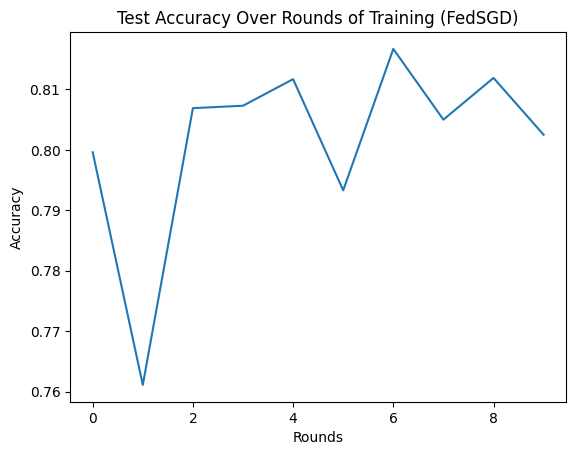

Final test accuracy: 0.8025000095367432


In [9]:
# 结果可视化：绘制训练过程中的准确率变化图 Visualization of results: Plot accuracy changes during training
plt.plot(accuracy_history)
plt.title('Test Accuracy Over Rounds of Training (FedSGD)')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.show()
print(f"Final test accuracy: {accuracy_history[-1]}")

In [10]:
print(f"Test accuracy: {accuracy_history}")

Test accuracy: [0.7996000051498413, 0.7610999941825867, 0.8069000244140625, 0.8072999715805054, 0.8116999864578247, 0.7932999730110168, 0.8166999816894531, 0.8050000071525574, 0.8119000196456909, 0.8025000095367432]
